## EM-ID

### Data Adquisition - Red Pitaya connection through SCPI server

In [ ]:
# CODE TO GENERATE DATA
import numpy as np
import pandas as pd
import redpitaya_scpi as scpi
import time
import datetime
import pickle
import scipy.stats as stats

# Set the IP address of the Red Pitaya
IP = '192.168.8.162'
rp_s = scpi.scpi(IP)

# User inputs to select operation mode
mode = input("Enter 'bgn' to capture background noise or 'emi' to capture EMI signal: ").strip().lower()

# Set whether to capture background noise (bgn) or EMI signal (emi)
if mode not in ['bgn', 'emi']:
    print("Invalid mode selected. Please choose 'bgn' or 'emi'.")
    exit()

# File to save data
if mode == 'bgn':
    save_file = "bgn_data.pkl"  # Background noise data saved here
elif mode == 'emi':
    save_file = "emi_data.pkl"  # EMI signal data saved here

# Define CSV file to store features
csv_file = f'live_{mode}_data_features.csv'

# Ensure a CSV header if not already present
header = ['index', 'timestamp', 'entropy', 'skewness', 'interquartile_range', 'kurtosis', 'percentile_75', 'range', 'maximum', 'median', 'percentile_90', 'mean_absolute_deviation', 'category']

# Write the header if the file doesn't exist
with open(csv_file, 'a') as f:
    f.seek(0, 2)  # Move to the end of the file
    if f.tell() == 0:  # If file is empty
        f.write(','.join(header) + '\n')

# Define function to compute statistics and save them to CSV
def compute_and_save_statistics(index, filtered_frequencies, filtered_power_dbm):
    # Calculate statistical features
    entropy = stats.entropy(np.abs(filtered_power_dbm))
    skewness = stats.skew(filtered_power_dbm)
    interquartile_range = np.percentile(filtered_power_dbm, 75) - np.percentile(filtered_power_dbm, 25)
    kurtosis = stats.kurtosis(filtered_power_dbm)
    percentile_75 = np.percentile(filtered_power_dbm, 75)
    value_range = np.ptp(filtered_power_dbm)
    maximum = np.max(filtered_power_dbm)
    median = np.median(filtered_power_dbm)
    percentile_90 = np.percentile(filtered_power_dbm, 90)
    mean_absolute_deviation = np.mean(np.abs(filtered_power_dbm - np.mean(filtered_power_dbm)))

    # Get current timestamp
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    # Save the statistics to the CSV file
    with open(csv_file, 'a') as f:
        f.write(f'{index},{timestamp},{entropy},{skewness},{interquartile_range},{kurtosis},{percentile_75},{value_range},{maximum},{median},{percentile_90},{mean_absolute_deviation}, "television-white"\n')

# Function to collect data and process every 5 seconds
def collect_data():
    index = 0
    while True:
        index += 1
        print("collect: ", index)
        # Configure Red Pitaya for signal acquisition
        decimation_factor = 1024  # Set a decimation factor for signal acquisition
        rp_s.tx_txt('ACQ:RST')  # Reset the acquisition
        rp_s.tx_txt(f'ACQ:DEC {decimation_factor}')  # Set decimation factor
        rp_s.tx_txt('ACQ:TRIG:LEV -5')  # Set trigger level
        rp_s.tx_txt('ACQ:START')  # Start the acquisition
        rp_s.tx_txt('ACQ:TRIG CH2_PE')  # Set trigger to positive edge on Channel 2

        # Wait for trigger and acquisition
        time.sleep(1)

        # Capture data from input 1
        rp_s.tx_txt('ACQ:SOUR2:DATA?')
        raw_data = rp_s.rx_txt()
        raw_data = raw_data.strip('{}\n\r').split(',')
        signal = np.array([float(x) for x in raw_data])

        # Remove DC component (subtract mean)
        signal = signal - np.mean(signal)

        # Perform FFT
        N = len(signal)
        sampling_rate = 125e6 / decimation_factor  # Adjust sampling rate based on decimation factor
        frequencies = np.fft.fftfreq(N, 1 / sampling_rate)[:N // 2]  # Only take positive frequencies
        fft_values = np.fft.fft(signal)[:N // 2]  # FFT for positive frequencies

        # Convert FFT to dBm assuming 50 ohms impedance
        Z_ref = 50  # Reference impedance in ohms
        power_mw = (np.abs(fft_values) ** 2) / Z_ref  # Power in milliwatts
        power_dbm = 10 * np.log10(power_mw)  # Convert to dBm

        # Apply a mask to only keep frequencies between 2 kHz and 5 MHz
        mask = (frequencies >= 2000) & (frequencies <= 5e6)
        filtered_frequencies = frequencies[mask]
        filtered_power_dbm = power_dbm[mask]

        # Save the signal data and FFT to a file
        with open(save_file, 'wb') as f:
            pickle.dump((signal, filtered_frequencies, filtered_power_dbm), f)

        # Compute and save features
        compute_and_save_statistics(index, filtered_frequencies, filtered_power_dbm)

        # Wait for 5 seconds before the next iteration
        time.sleep(0.5)

# Call the data collection function
collect_data()

### Model Training

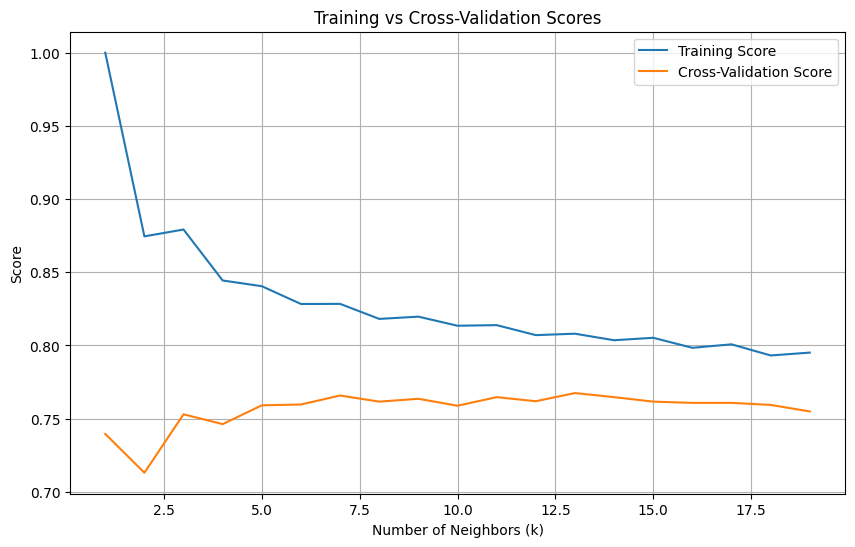

Best number of neighbors: 13
Best cross-validation score: 0.7674395954590433
Test set classification report:
                     precision    recall  f1-score   support

       "background"       0.76      0.75      0.75       355
       "mac_alonso"       0.96      1.00      0.98       217
 "television-white"       0.75      0.74      0.74       324

           accuracy                           0.81       896
          macro avg       0.82      0.83      0.83       896
       weighted avg       0.81      0.81      0.81       896



In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib

# Load the dataset
file_path = 'emi_data_features.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Drop 'index' and 'timestamp' columns
X = data.drop(columns=['index', 'timestamp', 'category'])
y = data['category']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the StandardScaler on the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the KNN model
knn = KNeighborsClassifier()

# Define the parameter grid
param_grid = {'n_neighbors': list(range(1, 20))}

# Use GridSearchCV to find the optimal number of neighbors
grid_search = GridSearchCV(knn, param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train_scaled, y_train)

# Save the best KNN model and the scaler
best_knn = grid_search.best_estimator_
joblib.dump(best_knn, 'knn_model.pkl')
joblib.dump(scaler, 'scaler.pkl')  # Save the fitted scaler

# Plot the training vs validation scores
results = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(10, 6))
plt.plot(results['param_n_neighbors'], results['mean_train_score'], label='Training Score')
plt.plot(results['param_n_neighbors'], results['mean_test_score'], label='Cross-Validation Score')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Score')
plt.title('Training vs Cross-Validation Scores')
plt.legend()
plt.grid(True)
plt.show()

# Print the best model's details
print(f"Best number of neighbors: {grid_search.best_params_['n_neighbors']}")
print(f"Best cross-validation score: {grid_search.best_score_}")

# Evaluate on the test set
y_pred = best_knn.predict(X_test_scaled)
print(f"Test set classification report:\n{classification_report(y_test, y_pred)}")


### GUI + Live Classification

In [4]:
import tkinter as tk
import pandas as pd
import joblib
import time
from threading import Thread

# Load the pre-trained KNN model and scaler
model = joblib.load('knn_model.pkl')
scaler = joblib.load('scaler.pkl')  # Load the fitted scaler

# File path for live data
live_file_path = 'live_emi_data_features.csv'

# Feature names (excluding 'index', 'timestamp', 'category')
feature_names = ['entropy', 'skewness', 'interquartile_range', 'kurtosis', 'percentile_75', 
                 'range', 'maximum', 'median', 'percentile_90', 'mean_absolute_deviation']

# Function to classify new data
def classify_data(features, feature_names):
    # Convert the features array to a DataFrame with the appropriate column names
    features_df = pd.DataFrame([features], columns=feature_names)
    
    # Scale the features using the loaded scaler
    scaled_features = scaler.transform(features_df)
    
    # Classify and get the top 3 categories
    probabilities = model.predict_proba(scaled_features)[0]
    top_3_indices = probabilities.argsort()[-3:][::-1]
    top_3_probabilities = probabilities[top_3_indices]
    top_3_categories = model.classes_[top_3_indices]
    
    return top_3_categories, top_3_probabilities

# Function to read the latest data entry
def get_latest_data():
    try:
        # Read the CSV file and get the last row
        data = pd.read_csv(live_file_path)
        latest_row = data.iloc[-1]
        
        # Extract the features and relevant metadata (index and timestamp)
        features = latest_row.drop(['index', 'timestamp', 'category']).values.astype(float)
        current_index = latest_row['index']
        timestamp = latest_row['timestamp']
        
        return features, current_index, timestamp
    except Exception as e:
        print(f"Error reading live data: {e}")
        return None, None, None

# Function to monitor the live data file and classify new data
def monitor_and_classify():
    last_index = -1
    while True:
        time.sleep(0.5)  # Check every 0.5 seconds
        try:
            data = pd.read_csv(live_file_path)
            current_index = data.index[-1]
            if current_index != last_index:
                last_index = current_index
                features, current_index, timestamp = get_latest_data()
                if features is not None:
                    top_3_categories, top_3_probabilities = classify_data(features, feature_names)
                    # Update the GUI with the classification result
                    result_label.config(text=f"Index: {current_index}, Timestamp: {timestamp}\n\n"
                                             f"Top 3 Categories:\n"
                                             f"1. {top_3_categories[0]} ({top_3_probabilities[0]:.2f})\n"
                                             f"2. {top_3_categories[1]} ({top_3_probabilities[1]:.2f})\n"
                                             f"3. {top_3_categories[2]} ({top_3_probabilities[2]:.2f})")
        except Exception as e:
            print(f"Error monitoring file: {e}")

# Create the main window
root = tk.Tk()
root.title("Live EMI Classification")

# Label to display the results
result_label = tk.Label(root, text="Waiting for data...")
result_label.pack()

# Start a background thread to monitor the live data file
thread = Thread(target=monitor_and_classify, daemon=True)
thread.start()

# Start the Tkinter event loop
root.mainloop()
